In [1]:
from google.colab import drive
drive.mount('/content/drive')

NotImplementedError: Mounting drive is unsupported in this environment. Use PyDrive instead. See examples at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2.

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
def load_data(image_size, labels, base_path):
    X = []
    Y = []
    for label in labels:
        folderPath = os.path.join(base_path, label)
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            Y.append(labels.index(label))
    return X, Y

In [5]:
image_size = 224
BATCH_SIZE = 32
NUM_CLASSES = 2
labels = ['covid', 'pneumonia']
base_path = '/kaggle/input/covid-pneumonia-lus-images/covid_pneumonia'

# Load data
X, Y = load_data(image_size, labels, base_path)

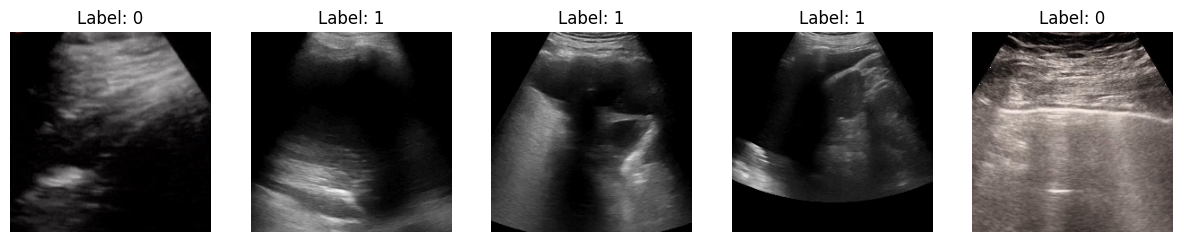

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to display random 5 images with labels
def show_random_images(X, Y, num_images=5):
    indices = random.sample(range(len(X)), num_images)  # Select random indices
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Create subplots

    for i, idx in enumerate(indices):
        axes[i].imshow(X[idx])  # Show image
        axes[i].set_title(f"Label: {Y[idx]}")  # Set label as title
        axes[i].axis("off")  # Hide axes

    plt.show()

# Call the function
show_random_images(X, Y)


In [7]:
# X = np.array(X)
# Y = np.array(Y)

# Step 1: Split into train + validation_temp and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 2: Split validation_temp into validation and test
# X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [9]:
def freeze_layers_with_exclusion(model, excluded_layers):
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the layers in the excluded list
    for name, param in model.named_parameters():
        if any(layer in name for layer in excluded_layers):
            param.requires_grad = True


def print_layers_req_grad(model):
    # Print all layers and their requires_grad status
    for name, param in model.named_parameters():
        print(f'Parameter: {name}, Requires Gradient: {param.requires_grad}')

In [10]:
import timm
import torch.nn as nn

# Define model parameters
pretrained = True  # Use pretrained weights
num_classes = 2   # Change this based on dataset

# Load the Swin Transformer model
print(f"\nUsing pretrained weights: {pretrained}\n")
model = timm.create_model('swin_tiny_patch4_window7_224.ms_in1k',
                          pretrained=pretrained,
                          num_classes=0)

# Freeze layers except classification head
if pretrained:
    excluded_layers = ['head']  # Keep only the classification head trainable
    freeze_layers_with_exclusion(model, excluded_layers)

# Get the number of input features for the classifier
num_features = model.num_features  # or model.get_classifier().in_features

# Define a new classification head
num_classes = 2  # Change based on your dataset
new_head = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

# Assign the new classification head
model.head = new_head  # For models like EfficientNet
# model.fc = new_head  # For models like ResNet (if applicable)

# Print model structure
print(model)



Using pretrained weights: True



model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [13]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()  # Since it's a classification task
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decays LR every 5 epochs


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import Dataset, DataLoader
from PIL import Image


# Define a Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # Assuming images are numpy arrays or PIL images
        self.labels = labels  # Assuming labels are integers
        self.transform = transform  # Apply transforms if given

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

# Define transformations (Resize, Normalize, etc.)
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create Dataset & Dataloaders
train_dataset = CustomDataset(X_train, Y_train, transform=transform)
test_dataset = CustomDataset(X_test, Y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [15]:
images, labels = next(iter(train_loader))
print("Image shape:", images.shape)   # Should be (batch_size, 3, H, W)
print("Label shape:", labels.shape)   # Should be (batch_size,)

# Ensure labels are integer class indices
print("Label dtype:", labels.dtype)   # Should be torch.int64 (long)
print("Unique labels:", labels.unique())  # Should contain class indices like [0,1,2,...]


Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])
Label dtype: torch.int64
Unique labels: tensor([0, 1])


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to GPU (if available)

import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

num_epochs = 5  # Set the number of epochs
all_preds, all_labels = [], []  # Store predictions for all epochs
train_losses = []  # Array to store training loss per epoch
train_accuracies = []  # Array to store training accuracy per epoch

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero out gradients
        # Extract feature maps
        features = model.forward_features(images)  # Shape: (batch_size, 7, 7, num_features)

        # Apply Adaptive Pooling to flatten spatial dimensions
        features = F.adaptive_avg_pool2d(features.permute(0, 3, 1, 2), (1, 1))  # (batch_size, num_features, 1, 1)
        features = features.view(features.shape[0], -1)  # Flatten to (batch_size, num_features)

        outputs = model.head(features)  # Pass through classifier
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Convert predictions to class labels
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

    # Calculate metrics for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average="macro")
    
    # Store metrics in arrays
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, F1 Score: {f1:.4f}")

    scheduler.step()  # Adjust learning rate

print("Training complete!")

# # Store loss and accuracy per epoch
# train_losses = []
# train_accuracies = []

# num_epochs = images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()  # Zero out gradients
#         # Extract feature maps
#         features = model.forward_features(images)  # Shape: (batch_size, 7, 7, num_features)

#         # Apply Adaptive Pooling to flatten spatial dimensions
#         features = F.adaptive_avg_pool2d(features.permute(0, 3, 1, 2), (1, 1))  # (batch_size, num_features, 1, 1)
#         features = features.view(features.shape[0], -1)  # Flatten to (batch_size, num_features)

#         outputs = model.head(features)  # Pass through classifier
#         loss = criterion(outputs, labels)  # Compute loss
#         loss.backward()  # Backpropagation
#         optimizer.step()  # Update weights

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)

#         # Convert predictions to class labels
#         all_preds.extend(predicted.cpu().numpy())  # Store predictions
#         all_labels.extend(labels.cpu().numpy())  # Store true labels

#     train_acc = 100 * correct / total
#     f1 = f1_score(all_labels, all_preds, average="macro")

#     # Store loss and accuracy for plotting
#     train_losses.append(running_loss / len(train_loader))
#     train_accuracies.append(train_acc)

#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%, F1 Score: {f1:.4f}")

#     scheduler.step()  # Adjust learning rate

# print("Training complete!")


Epoch 1/5, Loss: 0.1195, Accuracy: 97.59%, F1 Score: 0.9759
Epoch 2/5, Loss: 0.1023, Accuracy: 98.61%, F1 Score: 0.9809
Epoch 3/5, Loss: 0.0962, Accuracy: 98.23%, F1 Score: 0.9814
Epoch 4/5, Loss: 0.0940, Accuracy: 98.35%, F1 Score: 0.9819
Epoch 5/5, Loss: 0.0906, Accuracy: 98.86%, F1 Score: 0.9832
Training complete!


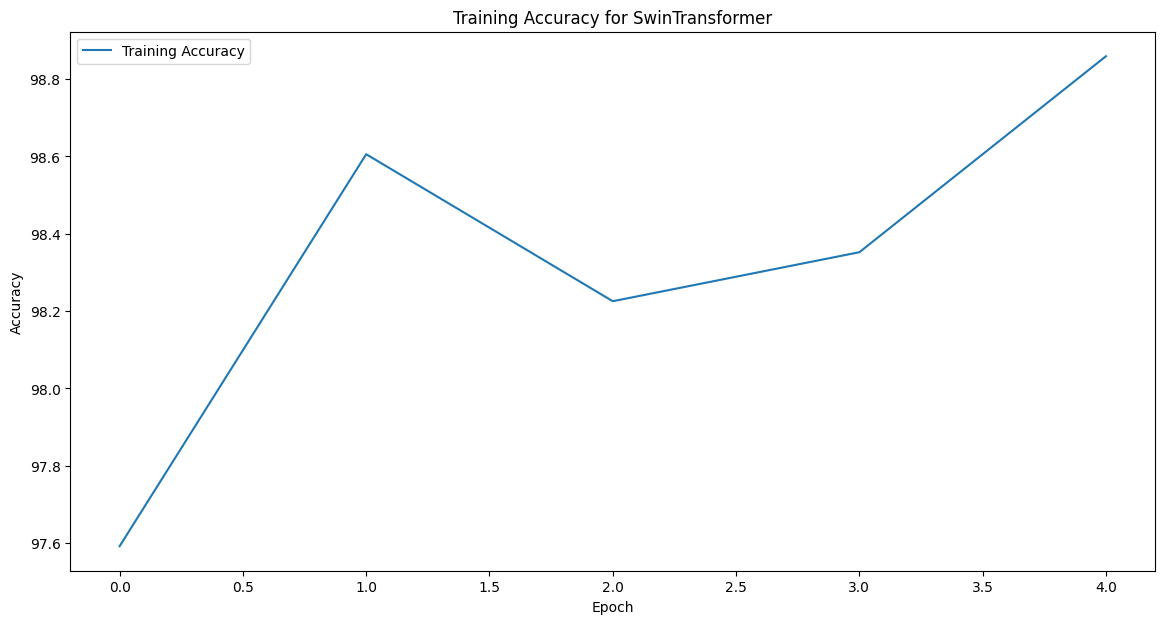

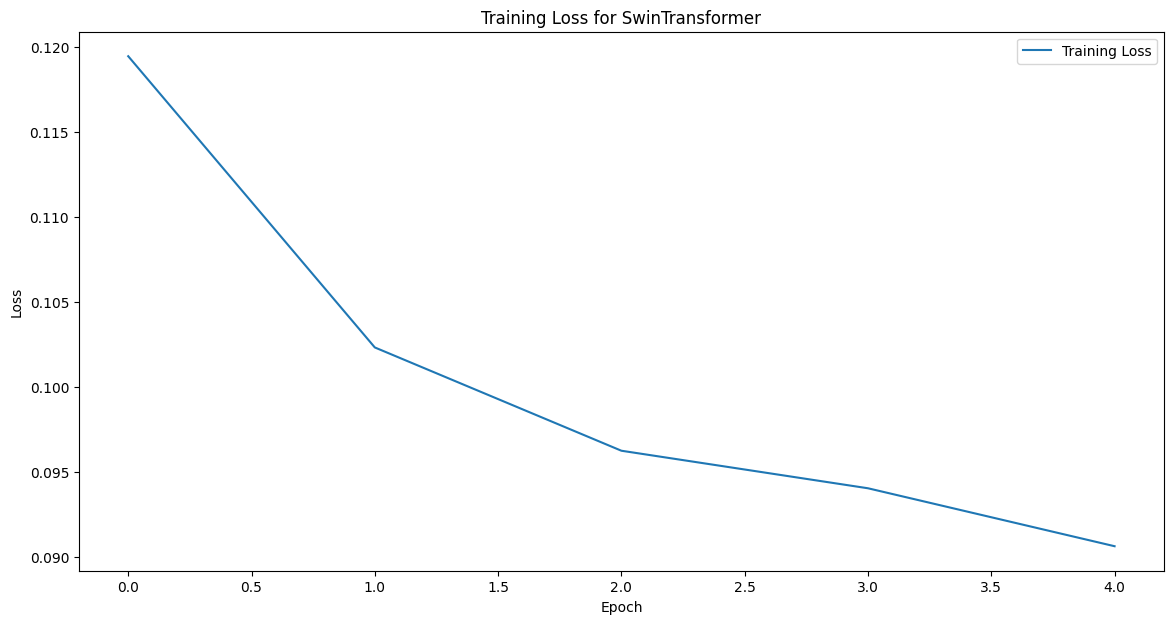

In [22]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(14, 7))
plt.plot(train_accuracies, label='Training Accuracy')
plt.title(f'Training Accuracy for {model.__class__.__name__}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(14, 7))
plt.plot(train_losses, label='Training Loss')
plt.title(f'Training Loss for {model.__class__.__name__}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [25]:
model.eval()  # Set to evaluation mode
correct, total = 0, 0
test_loss = 0.0
all_test_preds = []  # Array to store all predictions
all_test_labels = []  # Array to store all true labels

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Extract feature maps
        features = model.forward_features(images)  # Shape: (batch_size, 7, 7, num_features)

        # Apply Adaptive Pooling to flatten spatial dimensions
        features = F.adaptive_avg_pool2d(features.permute(0, 3, 1, 2), (1, 1))  # (batch_size, num_features, 1, 1)
        features = features.view(features.shape[0], -1)  # Flatten to (batch_size, num_features)

        # Forward pass through classifier
        outputs = model.head(features)  
        
        # Compute loss
        loss = criterion(outputs, labels)  
        test_loss += loss.item()

        # Compute accuracy and store predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Store predictions and labels
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute final metrics
test_acc = 100 * correct / total
test_loss /= len(test_loader)  # Average test loss

print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 98.48%
Test Loss: 0.0895


In [ ]:
print(f"Total test samples: {len(test_loader.dataset)}")
print(f"Total predictions collected: {len(all_preds)}")
print(f"Total labels collected: {len(all_labels)}")


In [ ]:
torch.save(model.state_dict(), "swinv2_finetuned.pth")


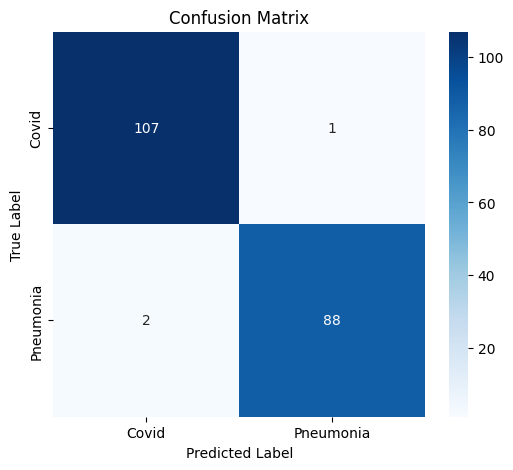

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_test_labels, all_test_preds)
class_names = ["Covid", "Pneumonia"]  # Change if you have different classes

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()